## Prize Collecting Steiner Tree (PCST)

### Problem definition

>** Given **
>A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$
>A root node $\{0\}$
>A profit $p_j > 0$ for each node $j \in V\{0\}$
>
>** Find **
>A subtree $T$ rooted in $\{0\}$ that maximizes the sum of the profits of >the nodes in $T$ **minus** the sum of the cost of the edges in $T$

### Directed formulation

Consider the bidirected graph $B=(V,A)$ that is obtained from $G$ by replacing each edge $e = \{i, j\}$ in $E$ with two directed arcs $(i, j)$ and
$(j, i)$ (with corresponding weights $c_{ij} = c_{ji} = c_e )$ and a cost $c_e > 0$ for each edge in $E$

> **PCST** is equivalent to find an optimal arborescence in B rooted in $\{0\}$


#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

#### Directed cut formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
\sum_{(i,j)\in \delta^+(S) x_{ij}} x_{ij}& \ge y_k \;\; \forall S \subset V, 0 \in S, k \in V\setminus S\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$

### Formulation with *positional* variables (MTZ formulation)

#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [1]:
import networkx as nx
import gurobi as gb
import pygraphviz as pygv
import argparse
from argparse import ArgumentTypeError
import pygraphviz as pygv
import os
from IPython.display import SVG, display


#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()

def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        elif y[i].x > 0.99999:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="gray", fontsize='8', width='0.3', fixedsize='true')

    for i in D.edges():
        if x[i].x > 0.999999:
            DrawG.add_edge(i[0], i[1], color='black')

    DrawG.layout(prog='neato', args='-n')	
    DrawG.draw (path=str(basename) + '_pcst_sol.svg', format='svg')
    DrawG.delete_edges_from(DrawG.edges())
    
class args:
    filename = None
    scale = 25

In [2]:
# 
# Read the graph in the graphML format
#

args.filename = 'expcst.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

D = G.to_directed()

G has 30 nodes and 435 edges


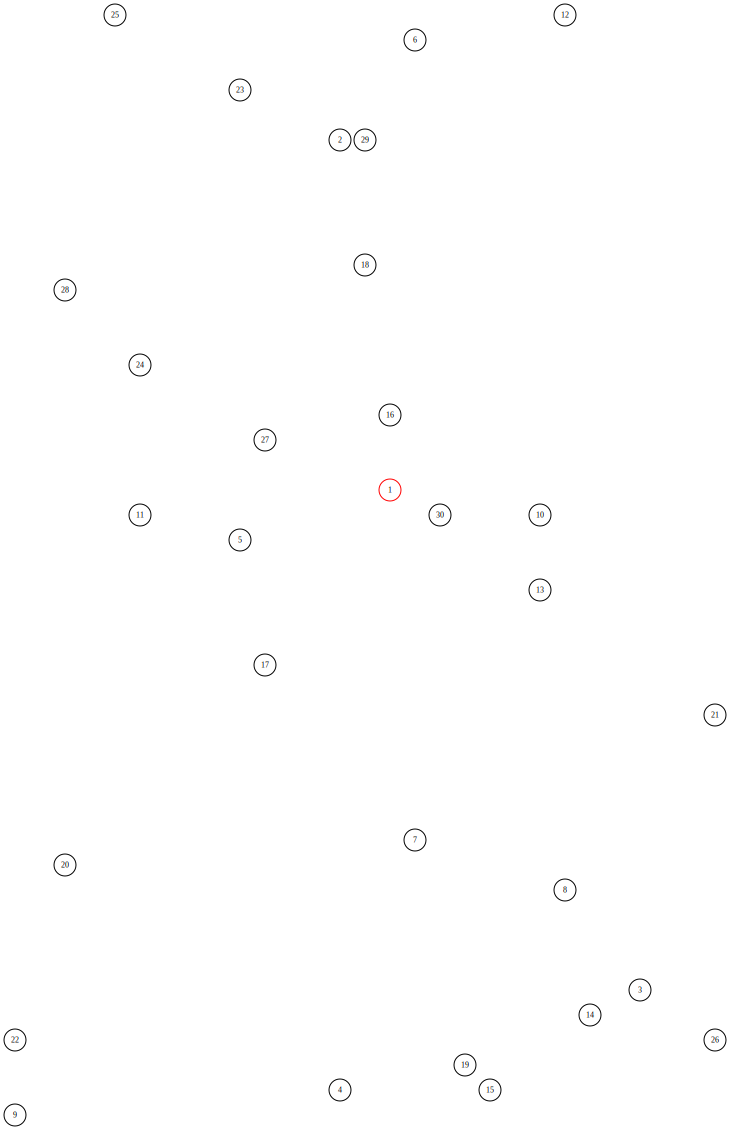

In [4]:
root = 1

DrawInitialGraph()

display(SVG(filename=basename+'.svg'))

In [5]:
pcst = gb.Model()


In [6]:
#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.node[i]['profit'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst.ModelSense = gb.GRB.MAXIMIZE

In [7]:
#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

In [8]:
#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] \
                 for j in G.nodes() if j != root), \
                name='Node')

pcst.update()

In [9]:
#
# Precedence constraints (MTZ constraints)
#

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] \
                + u[i] - u[j] <= G.number_of_nodes() \
                 for i,j in D.edges()),\
                name = 'MTZ')

pcst.update()

In [10]:
#
# Connectivity constraints
#

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 


In [11]:
pcst.write('pcst.lp')

In [12]:
pcst.optimize()

Optimize a model with 1741 rows, 930 columns and 5163 nonzeros
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 822.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.01s
Presolved: 1682 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 5.941968e+03, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5941.96774    0   22  822.00000 5941.96774   623%     -    0s
H    0     0                    2819.0000000 5941.96774   111%     -    0s
     0     0 4978.25000    0   36 2819.00000 4978.25000  76.6%     -    0s
     0     0 4978.25000    0   36 2819.00000 4978.25000  76.

In [13]:
totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']

print ("Total cost", totalcost)

Total cost 8482


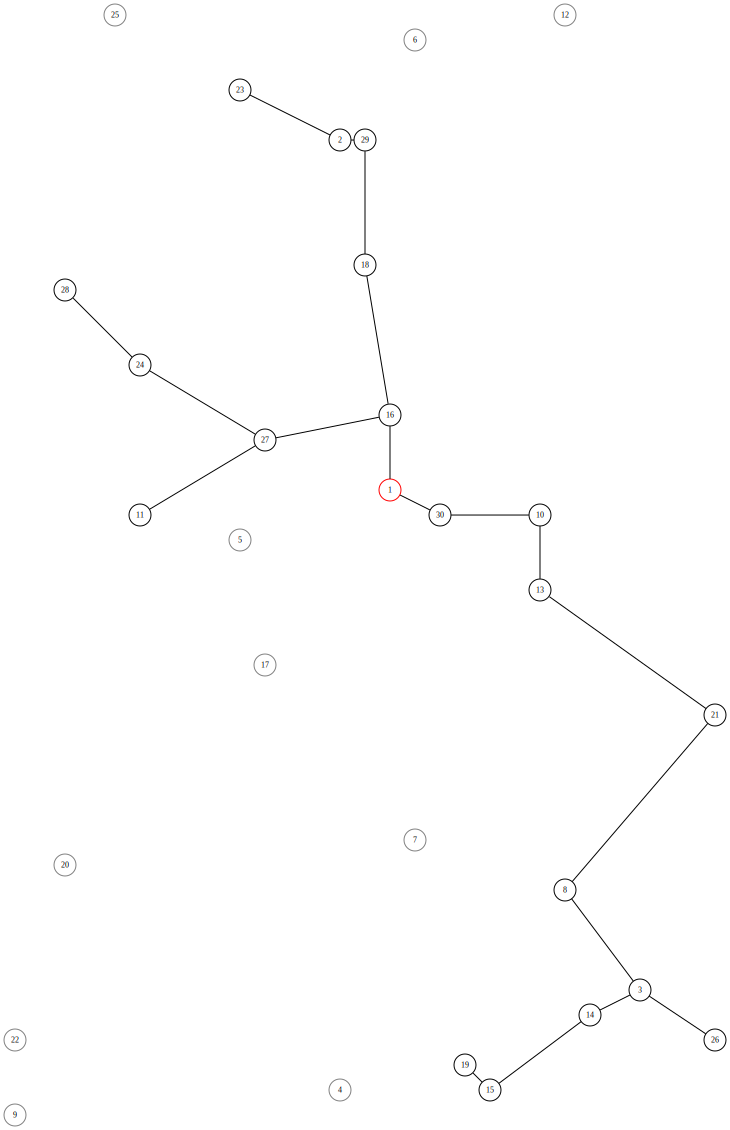

In [14]:
DrawSol(x)
display(SVG(filename=basename+'_pcst_sol.svg'))


